# Structure analysis

This notebook presents the tools to analyse the structure of solid solutions.


In [38]:
#import sys
#sys.path.insert(1, '../../crystal-code-tools/crystal_functions/crystal_functions/')

from crystal_functions.file_readwrite import Crystal_output, Properties_input, Properties_output, Crystal_input, write_cry_gui, write_crystal_input
from crystal_functions.execute import runcry
from crystal_functions.convert import cry_gui2pmg,cry_bands2pmg

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from ase.visualize import view

from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.surface import SlabGenerator
from pymatgen.electronic_structure.plotter import BSPlotter

import numpy as np
import pandas as pd
import shutil

## Generate the structures

In this instance, the structures were created by using the data/Configuration.txt file that contains a list of Li atom indices.

In [6]:
with open('data/Configuration.txt') as file:
    data = file.readlines()
manual_li = []
for line in data:
    if line.lstrip(' ').split(' ')[0] != '\n':
        manual_li.append([int(x) for x in line.rstrip('\n').lstrip(' ').rstrip(' ').split(' ')])


In [7]:
original_structure = cry_gui2pmg('data/LTS_CONFCNT_ONLY.gui')
new_atom = 'Li'
structures = []
ti_atoms = []
li_atoms = []
all_ti = [x for x in range(1,28)]
for j,substitutions in enumerate(manual_li):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures.append(new_structure)
    ti_atoms.append((np.array([i for i in all_ti if i not in manual_li[j]])-1).tolist())
li_atoms = (np.array(manual_li)-1).tolist()

## Visualise the structures


In [8]:
write_cry_gui('data/calculations/optgeom/LTS_37_B3LYP_Ahl_b.gui',structures[36])

In [9]:
view(AseAtomsAdaptor().get_atoms(structures[36]))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/test_env...>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Space group analysis (ADD DF)

In [10]:
space_group = []
for structure in structures:
    space_group.append(SpacegroupAnalyzer(structure).get_space_group_number())
#space_group

## Shells

In [11]:
shells = np.unique(np.round(structures[0].distance_matrix[0],decimals=6)).tolist()
shells

[0.0, 2.54275, 3.595992, 4.404172, 5.0855, 5.685762, 6.22844, 7.62825]

## Average Ti-Ti distance

In [12]:
average_ti = []
std_average_ti = []
average_std_ti_combined = []
for n,structure in enumerate(structures):
    average = 0.
    std_average = []
    for i in ti_atoms[n]:
        for j in ti_atoms[n]: 
            if i != j:
                average += round(structure.sites[i].distance(structure.sites[j]),6)
                std_average.append(structure.sites[i].distance(structure.sites[j]))
    average_ti.append(average/((len(ti_atoms[n]))*(len(ti_atoms[n])-1)))
    std_average_ti.append(np.std(std_average))
    average_std_ti_combined.append([average/(len(ti_atoms[n])**2),np.std(std_average)])

In [13]:
unique_ti_average = np.unique(np.sort(np.array(average_ti)),axis=0)
average_ti_group = []
for i in range(len(structures)):
    average_ti_group.append(np.where(unique_ti_average == average_ti[i])[0][0])

In [14]:
dist_std_unique, dist_std_first, dist_std_occ =  \
np.unique(np.round(np.array(average_std_ti_combined),6),axis=0,return_counts=True,return_index=True)

## Group structures

In [16]:
average_std_group = []
for unique in dist_std_unique:
    average_std_group.append(np.where(np.all(np.round(np.array(average_std_ti_combined),6) == unique,axis=1))[0].tolist())

## Select the structures
NB: the numbers used here refer to the numbering 1-4023.

In [17]:
selected_structures = [2, 37, 119, 127, 218, 348, 650, 721, 737, 840, 848, 868, 880, 1097, 1126,
                        1363, 1435, 1526, 1639, 1688, 1887, 2312, 2801, 3579, 3842]

## Plot the average Ti-Ti distance vs the Ti-Ti distance std

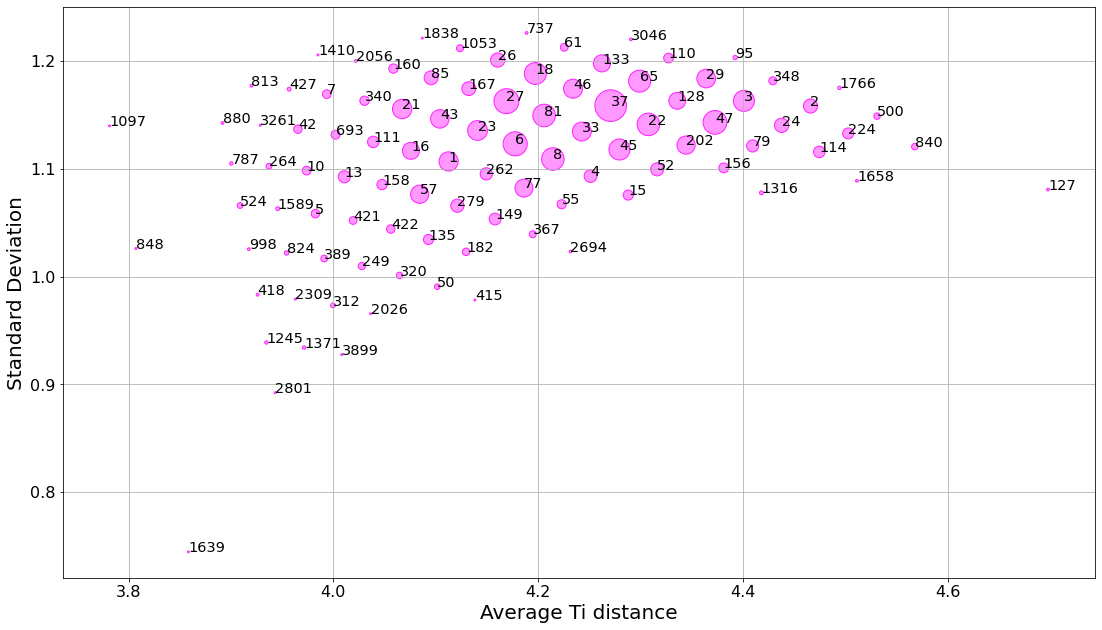

In [18]:
import matplotlib.pyplot as plt

font = {'size'   : 14.5,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#ff22ff', color='#ff99ff')

label = dist_std_first+1

ax.set_xlabel('Average Ti distance', fontsize=20)
ax.set_ylabel('Standard Deviation', fontsize=20) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.grid()

for i, txt in enumerate(label):
    ax.annotate(txt, (dist_std_unique[i,0], dist_std_unique[i,1]),)
fig.set_size_inches(18.5, 10.5)

plt.show()

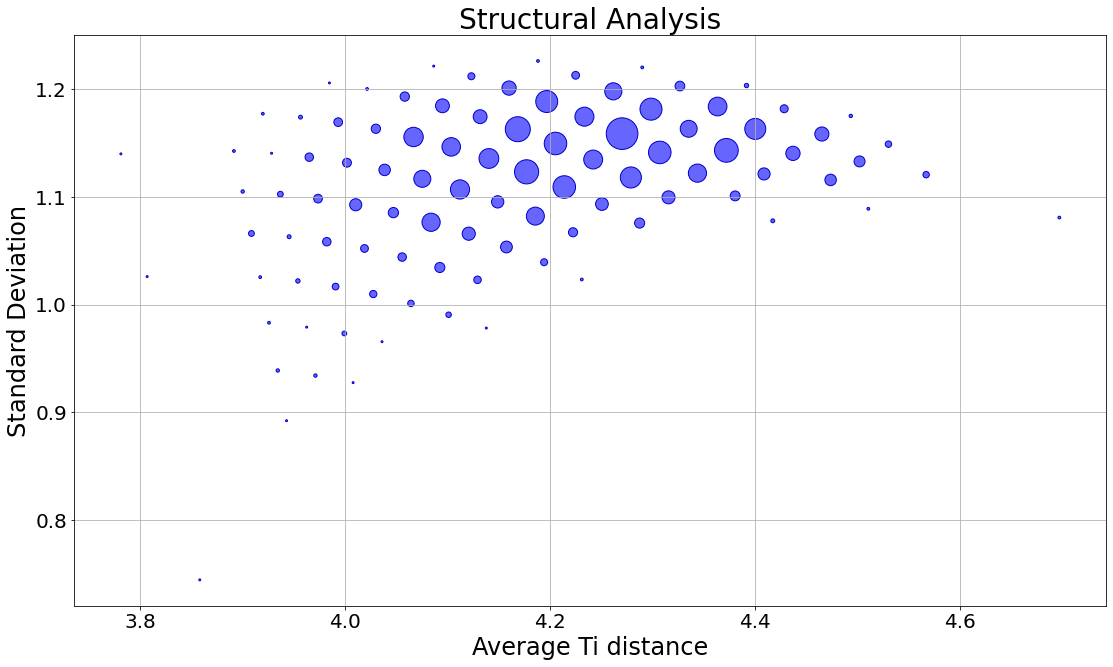

In [19]:
import matplotlib.pyplot as plt


font = {'size'   : 14,
       'weight': 'normal'}

plt.rc('font', **font)

color = ['b','g','r','c','m','y','k','tab:orange']
fig, ax = plt.subplots()
ax.scatter(dist_std_unique[:,0], dist_std_unique[:,1],s=dist_std_occ/max(dist_std_occ)*1000, 
           edgecolors='#0000CC', color='#6666FF')

label = selected_structures

ax.set_xlabel('Average Ti distance', fontsize=24)
ax.set_ylabel('Standard Deviation', fontsize=24) 
ax.set_title('Structural Analysis', fontsize=28) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid()

'''for i, txt in enumerate(label):
    x = average_std_ti_combined[int(txt)-1][0]
    y = average_std_ti_combined[int(txt)-1][1]
    
    mult = count_selected[np.where(unique_selected == round(x,6))[0][0]]
    b
    xytext = (x,y+-0.007*i)
    ax.annotate(txt,xy=(x,y),xytext=xytext,xycoords='data',arrowprops={'arrowstyle':'-'})
'''
fig.set_size_inches(18.5, 10.5)
fig.savefig("structural_analysis.png")
plt.show()

In [20]:
description = ['Ti rows','Ti rows','Dispersed', 'Ti spiral','Ti rows',
               'Dispersed','Dispersed','Ti rows','Ti rows',
               'Dispersed','Ti rows','Dispersed','Vicinal Ti rows',
               'Ti Planes (1 0 0)','Dispersed','Dispersed','Ti rows','Dispersed',
               'Ti Planes (1 1 1)','Dispersed','Dispersed','Ti rows','Ti rows','Dispersed','Dispersed']

## Write input files

In [40]:
cry_input = Crystal_input('data/calculations/optgeom/optgeom_file.d12')
for structure in selected_structures:
    write_cry_gui('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.gui_inp'%structure,structures[structure-1])
    write_crystal_input('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.d12'%structure,crystal_input=cry_input)

## Optimised structure analysis - geometry

In [23]:
coord = 6

li_s_distance_average = []
li_s_distance_min = []
li_s_distance_max = []

ti_s_distance_average = []
ti_s_distance_min = []
ti_s_distance_max = []

ti_li_distance_average = []
ti_li_distance_min = []
ti_li_distance_max = []

ti_s_distance_min_average = []
ti_s_distance_max_average = []

for structure in selected_structures:    
    opt_geom = cry_gui2pmg('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.gui'%structure)
    li_atoms = np.where(np.array(opt_geom.atomic_numbers) == 3)[0]
    ti_atoms = np.where(np.array(opt_geom.atomic_numbers) == 22)[0]
    s_atoms = np.where(np.array(opt_geom.atomic_numbers) == 16)[0]
    li_s_distances = []
    ti_s_distances = []
    ti_li_distances = []
    
    for li_atom in li_atoms:
        for s_atom in s_atoms:
            li_s_distances.append(opt_geom.distance_matrix[li_atom][s_atom])
    li_s_distance_average.append(np.average(np.sort(np.array(li_s_distances))[0:len(li_atoms)*coord]))
    li_s_distance_min.append(np.min(np.sort(np.array(li_s_distances))[0:len(li_atoms)*coord]))
    li_s_distance_max.append(np.max(np.sort(np.array(li_s_distances))[0:len(li_atoms)*coord]))
    
    ti_s_mins = []
    ti_s_maxs = []
    
    for ti_atom in ti_atoms:
        for li_atom in li_atoms:
            ti_li_distances.append(opt_geom.distance_matrix[ti_atom][li_atom])
    ti_li_distance_average.append(np.average(np.sort(np.array(ti_li_distances))[0:len(ti_atoms)*coord]))
    ti_li_distance_min.append(np.min(np.sort(np.array(ti_li_distances))[0:len(ti_atoms)*coord]))
    ti_li_distance_max.append(np.max(np.sort(np.array(ti_li_distances))[0:len(ti_atoms)*coord]))
    
    ti_s_mins = []
    ti_s_maxs = []
    
    for ti_atom in ti_atoms:
        
        ti_s_distances_single = []
        for s_atom in s_atoms:
            ti_s_distances.append(opt_geom.distance_matrix[ti_atom][s_atom])
            ti_s_distances_single.append(opt_geom.distance_matrix[ti_atom][s_atom])
        ti_s_mins.append(np.sort(np.array(ti_s_distances_single))[0:coord][0])
        ti_s_maxs.append(np.sort(np.array(ti_s_distances_single))[0:coord][-1])
        
    ti_s_distance_average.append(np.average(np.sort(np.array(ti_s_distances))[0:len(ti_atoms)*coord]))
    ti_s_distance_min.append(np.min(np.sort(np.array(ti_s_distances))[0:len(ti_atoms)*coord]))
    ti_s_distance_max.append(np.max(np.sort(np.array(ti_s_distances))[0:len(ti_atoms)*coord]))
    
    ti_s_distance_min_average.append(np.average(ti_s_mins))
    ti_s_distance_max_average.append(np.average(ti_s_maxs))
    
#print(ti_s_distance_average,ti_s_distance_min,ti_s_distance_max)

In [24]:
ti_s_delta_distance_average = ((np.array(ti_s_distance_average)/2.438731)-1)*100
ti_s_delta_distance_min = ((np.array(ti_s_distance_min)/2.438731)-1)*100
ti_s_delta_distance_max = ((np.array(ti_s_distance_max)/2.438731)-1)*100

li_s_delta_distance_average = ((np.array(li_s_distance_average)/2.438731)-1)*100
li_s_delta_distance_min = ((np.array(li_s_distance_min)/2.438731)-1)*100
li_s_delta_distance_max = ((np.array(li_s_distance_max)/2.438731)-1)*100

## Optimised structure analysis - Energy 

In [30]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.structure import Structure
energy = []
band_gap = []
volume_prim = []
volume_conv = []
a = []
b = []
c = []
alpha = []
beta = []
gamma = []
converged = []
mulliken_ti = []
mulliken_li = []
mulliken_s = []
for structure in selected_structures:
    cry_out = Crystal_output('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.out'%structure)
    energy.append(cry_out.get_final_energy())
    band_gap.append(cry_out.get_band_gap())
    converged.append(cry_out.converged)
    structure_pmg = cry_gui2pmg('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.gui'%structure)
    volume_prim.append(structure_pmg.volume)
    mulliken_ti.append(np.average(np.array(cry_out.get_mulliken_charges())[np.where(np.array(structure_pmg.atomic_numbers) == 22)])-22)
    mulliken_li.append(np.average(np.array(cry_out.get_mulliken_charges())[np.where(np.array(structure_pmg.atomic_numbers) == 3)])-3)
    mulliken_s.append(np.average(np.array(cry_out.get_mulliken_charges())[np.where(np.array(structure_pmg.atomic_numbers) == 16)])-16)
      
    #Make conventional cell
    structure_pmg.make_supercell([[-1,1,1],[1,-1,1],[1,1,-1]])
    lattice = [structure_pmg.lattice.a,structure_pmg.lattice.b,structure_pmg.lattice.c]
    angles= [structure_pmg.lattice.alpha,structure_pmg.lattice.beta,structure_pmg.lattice.gamma]
    a.append(lattice[0])
    b.append(lattice[1])
    c.append(lattice[2])
    alpha.append(angles[0])
    beta.append(angles[1])
    gamma.append(angles[2])
    volume_conv.append(structure_pmg.volume)
    
energy = np.array(energy)

## Reference structure - monocline

In [31]:
monocline_out = Crystal_output('data/calculations/optgeom/LTS_monocline.out')
monocline = cry_gui2pmg('data/calculations/optgeom/LTS_monocline.gui')
energy_norm = (energy/9.) - (monocline_out.get_final_energy()/2.)

## Display results

In [32]:
df = pd.DataFrame(list(zip(ti_s_distance_min,ti_s_distance_max,
                           li_s_distance_min,li_s_distance_max,
                            ti_li_distance_min, ti_li_distance_max, volume,
                          np.round(energy,3),np.round(band_gap,3),description,
                           )),
                           #a,b,c,alpha,beta,gamma,converged)),
                 columns=['Ti-S min','Ti-S max',
                          'Li-S min','Li-S max',
                          'Ti-Li min','Ti-Li max', 'Volume',
                          'Energy/unit formula (eV)',
                          'Band Gap (eV)','Description',
                          ],
                          #'a','b','c','alpha','beta','gamma','Converged (TMP)'],
                 index=selected_structures)

df.index.name = 'Structure ID'
df.sort_values('Energy/unit formula (eV)', axis=0, ascending=True, inplace=False)


NameError: name 'volume' is not defined

In [33]:
df = pd.DataFrame(list(zip(ti_s_distance_min,ti_s_distance_max,
                           li_s_distance_min,li_s_distance_max,
                            ti_li_distance_min, ti_li_distance_max, 
                          energy,np.round(energy_norm,3),np.round(band_gap,3),
                           a,b,c,
                           alpha,beta,gamma,
                           volume_prim, volume_conv,
                           np.array(volume_conv)/volume_conv,
                           mulliken_ti,mulliken_li,mulliken_s,
                           description,
                           )),
                           #a,b,c,alpha,beta,gamma,converged)),
                 columns=['Ti-S min','Ti-S max',
                          'Li-S min','Li-S max',
                          'Ti-Li min','Ti-Li max', 'Energy/unit formula (eV)',
                          'Energy/unit formula (-E mono) (eV)',
                          'Band Gap (eV)',
                          'a','b','c','alpha','beta','gamma',
                          'volume prim','volume conv',
                          'volume percent',
                          'mulliken Ti','mulliken Li','mulliken S',
                          'Description',
                          ],
                          #'a','b','c','alpha','beta','gamma','Converged (TMP)'],
                 index=selected_structures)

df.index.name = 'Structure ID'
df.sort_values('Energy/unit formula (eV)', axis=0, ascending=True, inplace=True)
df.to_csv('data/table.csv')
display(df)

,Ti-S min,Ti-S max,Li-S min,Li-S max,Ti-Li min,Ti-Li max,Energy/unit formula (eV),Energy/unit formula (-E mono) (eV),Band Gap (eV),a,...,alpha,beta,gamma,volume prim,volume conv,volume percent,mulliken Ti,mulliken Li,mulliken S,Description
Structure ID,,,,,,,,,,,,,,,,,,,,,
1887,2.226625,3.302111,2.492272,2.999800,3.297511,3.785151,-504326.501062,0.146,2.465,15.598708,...,89.676128,90.413083,89.776342,948.993126,3795.972503,1.0,-0.635444,-0.853056,0.780556,Dispersed
1363,2.200816,3.167235,2.523228,2.937446,3.286107,3.758590,-504326.489641,0.148,2.531,15.799025,...,89.981626,90.175901,90.223733,950.805397,3803.221587,1.0,-0.634111,-0.852833,0.779889,Dispersed
1126,2.209867,3.399513,2.516503,3.127554,3.289944,3.796116,-504326.340153,0.164,2.509,15.495596,...,89.764168,89.642763,90.351564,953.415142,3813.660569,1.0,-0.636333,-0.852667,0.780556,Dispersed
3842,2.197000,3.408835,2.499958,3.011152,3.290508,3.796627,-504326.256177,0.174,2.549,15.408030,...,90.432207,90.939113,90.848138,954.159742,3816.638967,1.0,-0.646556,-0.853056,0.784185,Dispersed
348,2.208594,3.425028,2.482538,3.025510,3.264249,3.772614,-504326.227486,0.177,2.476,15.522684,...,89.376152,89.921301,90.594169,954.547239,3818.188955,1.0,-0.637444,-0.853167,0.781148,Dispersed
1526,2.208455,3.427115,2.482923,3.028844,3.263845,3.771067,-504326.227402,0.177,2.476,15.524178,...,89.380868,89.928765,90.600226,954.408476,3817.633906,1.0,-0.637444,-0.853167,0.781185,Dispersed
650,2.208197,3.428830,2.482435,3.032358,3.263824,3.771036,-504326.226982,0.177,2.476,15.524994,...,89.373576,89.931448,90.596157,954.601407,3818.405626,1.0,-0.637444,-0.853167,0.781296,Dispersed
3579,2.208275,3.430005,2.484299,3.033405,3.263670,3.765596,-504326.226704,0.177,2.478,15.525600,...,89.375282,89.932341,90.603673,954.455966,3817.823864,1.0,-0.637556,-0.853167,0.781111,Dispersed
868,2.219717,3.221629,2.492059,3.109709,3.325191,3.813988,-504326.175541,0.182,2.199,15.462745,...,90.258666,90.044209,90.017003,952.320764,3809.283055,1.0,-0.633556,-0.853278,0.779963,Dispersed


## Subset of structures

In [34]:
df.loc[[1887,1363,1126,1435,1097,218,37]]

,Ti-S min,Ti-S max,Li-S min,Li-S max,Ti-Li min,Ti-Li max,Energy/unit formula (eV),Energy/unit formula (-E mono) (eV),Band Gap (eV),a,...,alpha,beta,gamma,volume prim,volume conv,volume percent,mulliken Ti,mulliken Li,mulliken S,Description
Structure ID,,,,,,,,,,,,,,,,,,,,,
1887,2.226625,3.302111,2.492272,2.999800,3.297511,3.785151,-504326.501062,0.146,2.465,15.598708,...,89.676128,90.413083,89.776342,948.993126,3795.972503,1.0,-0.635444,-0.853056,0.780556,Dispersed
1363,2.200816,3.167235,2.523228,2.937446,3.286107,3.758590,-504326.489641,0.148,2.531,15.799025,...,89.981626,90.175901,90.223733,950.805397,3803.221587,1.0,-0.634111,-0.852833,0.779889,Dispersed
1126,2.209867,3.399513,2.516503,3.127554,3.289944,3.796116,-504326.340153,0.164,2.509,15.495596,...,89.764168,89.642763,90.351564,953.415142,3813.660569,1.0,-0.636333,-0.852667,0.780556,Dispersed
1435,2.182177,3.948312,2.320313,3.981489,2.964100,4.127781,-504321.523851,0.699,1.706,17.059597,...,91.561043,86.699641,90.661508,1030.194604,4120.778417,1.0,-0.564667,-0.849611,0.754630,Ti rows
1097,2.152243,4.001951,2.288501,3.977018,3.304035,4.230203,-504321.558421,0.695,1.795,14.113648,...,89.223738,90.229381,90.902575,1046.592702,4186.370809,1.0,-0.573111,-0.852167,0.759222,Ti Planes (1 0 0)
218,2.168563,4.183320,2.293672,3.749361,2.957146,3.880659,-504322.518462,0.589,1.854,18.777048,...,82.302135,100.821379,87.372340,1002.549046,4010.196184,1.0,-0.573778,-0.850611,0.758222,Ti rows
37,2.542740,2.542758,2.542740,2.542759,3.595984,3.595993,-504325.394724,0.269,1.957,15.300343,...,88.683012,90.368989,88.583888,955.439503,3821.758010,1.0,-0.634111,-0.854167,0.780852,Ti rows


## Identify row-containing structures

In [ ]:
ti_second_shell_atom = []
n_atoms_second_shell = []
for n,structure in enumerate(structures):
    distance = []
    distance_atoms = []
    for i in ti_atoms[n]:
        dist = 0
        dist_atom = []
        for j in ti_atoms[n]:
            #if round(structure.sites[i].distance(structure.sites[j]),6) == round(shells[2],6):
            if round(structure.distance_matrix[i][j],6) == round(shells[2],6):
                #print(i,j,structure.sites[i].distance(structure.sites[j]))
                dist += 1
                dist_atom.append(j)
        distance_atoms.append(dist_atom)
        distance.append(dist)
        max_coord_atoms = max(enumerate(distance_atoms), key = lambda tup: len(tup[1]))[1]
        atom_coords = []
        '''for atom in max_coord_atoms:
            atom_coords.append(structure.cart_coords[atom].tolist())'''
    n_atoms_second_shell.append(distance)
    ti_second_shell_atom.append(distance_atoms)




In [ ]:
def get_angle(a,b,c):

    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

In [ ]:
linear = []
for n,structure in enumerate(structures):
    line = False
    for i in range(len(ti_atoms[0])):
        for j in ti_second_shell_atom[n][i]:
            for k in ti_second_shell_atom[n][i]:
                if j != k:
                    #print(ti_atoms[n][i],j,k,get_angle(structure.cart_coords[j],structure.cart_coords[ti_atoms[n][i]],structure.cart_coords[k]))
                    #print(ti_atoms[n][i],j,k,np.round(get_angle(structure.cart_coords[j],structure.cart_coords[ti_atoms[n][i]],structure.cart_coords[k]),4))
                    if np.round(get_angle(structure.cart_coords[j],
                                          structure.cart_coords[ti_atoms[n][i]],
                                          structure.cart_coords[k]),4) == 180.0:
                        line = True
                        
    linear.append(line)

In [ ]:
linear

In [ ]:
multiplicity = pd.read_csv('data/multiplicity.csv',header=None,delimiter='\n').to_numpy().flatten()
np.unique(multiplicity)

## Partition function

In [ ]:
k = 8.617333262145E-5
T = 298.15

deltaE_1 = 0.35
#deltaE_1 = 0.4
exponential_1 = -deltaE_1/(k*T) #left in the graph

deltaE_2 = 0.1
exponential_2 = -deltaE_2/(k*T) #right in the graph


#From graph
exponential = np.zeros(len(structures))

nanostr = np.array(average_std_ti_combined)[:,0] < 4.6
exponential[np.where(nanostr == False)] = exponential_2 #dispersed
exponential[np.where(nanostr == True)] = exponential_1 #ordered
print(np.unique(np.exp(exponential)))
#q_linear_structures = np.sum(multiplicity[np.where(np.array(linear) == True)]*np.exp(exponential_1))
#q_non_linear_structures = np.sum(multiplicity[np.where(np.array(linear) == False)]*np.exp(exponential_2))

#q_tot = q_linear_structures + q_non_linear_structures
q_tot = np.sum(multiplicity*np.exp(exponential))

probability = (multiplicity*np.exp(exponential))/q_tot

probability_nanostr = np.sum(probability[np.where(nanostr == True)])
probability_dispersed = np.sum(probability[np.where(nanostr == False)])
print('probability_nanostr',probability_nanostr)
print('probability_dispersed',probability_dispersed)

In [ ]:
multiplicity[649]

In [ ]:
np.unique(np.exp(exponential))

In [ ]:
q = (100*(2.04009370e-02)) + (4500000*(1.73220966e-06))

In [ ]:
(100*(2.04009370e-02))/q

In [ ]:
(4500000*(1.73220966e-07))/q

In [ ]:
np.exp()

In [ ]:
np.sum(multiplicity*(nanostr-1))

In [ ]:
4.2
probability_linear 0.5750830913543863
probability_non_linear 0.42491690864561343

4.4
probability_linear 0.4193821433612588
probability_non_linear 0.5806178566387412

3.8

# THE END

In [ ]:
df = pd.DataFrame(list(zip(ti_s_delta_distance_average,ti_s_delta_distance_min,ti_s_delta_distance_max,
                           li_s_delta_distance_average,li_s_delta_distance_min,li_s_delta_distance_max,
                          energy,band_gap,description,converged)),
                 columns=['Ti-S average','Ti-S min','Ti-S max','Li-S average','Li-S min','Li-S max','Energy/unit formula',
                          'Band Gap (eV)','Description','Converged (TMP)'],
                 index=selected_structures)
df.sort_values('Energy/unit formula', axis=0, ascending=True, inplace=False)

## Band structures

### Write input

In [39]:
for structure in selected_structures:
    shutil.copy('data/calculations/bands/band_input.d3','data/calculations/bands/LTS_%s_bands.d3'%structure)

### Plot bands

In [ ]:
%matplotlib inline
for structure in selected_structures:
    output = Crystal_output('data/calculations/optgeom/LTS_%s_B3LYP_Ahl_b.out'%structure)
    bands = Crystal_bands('data/calculations/bands/LTS_%s_bands.BAND'%structure)
    bs = cry_bands2pmg(output,bands)
    bsplot = BSPlotter(bs)
    bsplot.get_plot(ylim=(-10, 10), zero_to_efermi=True)

## Density of States

### Write input

In [36]:
with open('data/calculations/doss/doss_file.d3') as file:
    data = file.readlines()
for structure in selected_structures:
    input_dos = data
    structure_n = structure-1
    atomic_n = structures[structure_n].atomic_numbers
    #print(atomic_n)
    data[5] = '-18 '+' '.join(str(x) for x in np.where(np.array(atomic_n) == 3)[0]+1)+ '\n'
    data[6] = '-9 '+' '.join(str(x) for x in np.where(np.array(atomic_n) == 22)[0]+1)+ '\n'
    data[7] = '-27 '+' '.join(str(x) for x in np.where(np.array(atomic_n) == 16)[0]+1)+ '\n'
    with open('data/calculations/doss/LTS_%s_doss.d3'%structure, 'w') as file:
        for line in data:
            file.writelines(line)

## Dataframe distances

In [ ]:
df = pd.DataFrame(list(zip(ti_s_distance_average,ti_s_distance_min,ti_s_distance_max,
                           li_s_distance_average,li_s_distance_min,li_s_distance_max,
                            energy, desc)),
                 columns=['Ti-S average','Ti-S min','Ti-S max','Li-S average','Li-S min','Li-S max','Energy'],
                 index=selected_structures)
df